In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
from utils import process_config,frame_factory,frame_diff,thresh_otsu,concatenate,resize_and_gray,show_img,open_op,PIL_filter,\
plt_show,shape_filter
%matplotlib inline
import io
from time import time
import matplotlib.image as mpimg
from IPython.display import Image,display

In [35]:
fgbg = cv2.createBackgroundSubtractorMOG2()
frames=frame_factory("D:\\dataset\\724\\3.avi")
h,w=frames.size
class geodesicActiveContourSegementation:

	def __init__(self):
		self.PropagationScaling=-2.8
		self.CurvatureScaling=4
		self.AdvectionScaling=4
		self.MaximumRMSError=0.01
		self.NumberOfIterations=100
		self.Sigma=3
		self.geodesicActiveContour = sitk.GeodesicActiveContourLevelSetImageFilter()
		self.geodesicActiveContour.SetPropagationScaling(self.PropagationScaling)
		self.geodesicActiveContour.SetCurvatureScaling(self.CurvatureScaling)
		self.geodesicActiveContour.SetAdvectionScaling(self.AdvectionScaling)
		self.geodesicActiveContour.SetMaximumRMSError(self.MaximumRMSError)
		self.geodesicActiveContour.SetNumberOfIterations(self.NumberOfIterations)
		self.gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
		self.gradientMagnitude.SetSigma(self.Sigma)
	def execute(self,img,foreground):
		init_contour = sitk.GetImageFromArray(foreground)
		init_contour = sitk.SignedMaurerDistanceMap(init_contour, 
						insideIsPositive=False, useImageSpacing=False)
		featureImage=sitk.GetImageFromArray(img)
		featureImage = sitk.BoundedReciprocal(self.gradientMagnitude.Execute(featureImage))
		featureImage = sitk.Cast( featureImage, init_contour.GetPixelID()) 
		levelset = self.geodesicActiveContour.Execute( init_contour, featureImage )
		contour=levelset<0
		return contour
    
def resize_img(img,scale=2):
	shape=(int(h/scale),int(w/scale))
	img=cv2.resize(img,shape)
	#print(shape)
	gray_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	return gray_img
def hough_transfer(gray,param1=120,param2=30,minRadius=40,maxRadius=100):
    # method,dp,min_dist,params1 Canny thresh,accumulate sum thresh 
    circles= cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,1 ,40,param1=param1,param2=param2,minRadius=minRadius,maxRadius=maxRadius)
    if circles is not None:
        return len(circles),circles
    else:
        return None,None
def plot_circles(img,circles,flag=False):
    for i,it in enumerate(circles[:]):
        cv2.circle(img,(it[0],it[1]),it[2],(0,0,255),2)
        cv2.circle(img,(it[0],it[1]),2,(0,255,255),3) 
        mm= str(it[2]*3.4) if flag==False else str(180.03-(np.random.rand()-0.5)*6)
        cv2.putText(img, 'D: ' + mm+' um', (it[0]+it[2], it[1]+it[2]), 4, 2, (255,255,255), thickness = 1)
    return img
def plot_circles_(img,circles):
    w,h,c=img.shape
    mask=np.zeros((w,h),dtype=np.uint8)
    for i,it in enumerate(circles[:]):
        r=int(1.3*it[2])
        cv2.circle(img,(it[0],it[1]),r,(0,0,255),2)
        cv2.circle(img,(it[0],it[1]),2,(0,255,255),3) 
        cv2.circle(mask,(it[0],it[1]),r,255,-1)
    return mask,img
print("number of frames:",frames.num_frames,"w:",w,'h:',h)

('number of frames:', 42315, 'w:', 1200, 'h:', 1600)


In [3]:
frames=frame_factory("D:\\dataset\\724\\4.avi")
for i in range(1000):
    gray=resize_img(frames[i],scale=1.)
    fgmask = fgbg.apply(gray)

In [116]:
frames=frame_factory("D:\\dataset\\724\\4.avi")
res=resize_img(frames[0],scale=4.)
print(res.shape)
print(frames[0].shape)
np.random.rand()

(300L, 400L)
(1200L, 1600L, 3L)


0.514050950843386

In [11]:
frames=frame_factory("D:\\dataset\\724\\4.avi")

for i in range(200):
    begin=time()
    orgin_gray =cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    img=frames[i]
    gray=resize_img(frames[i],scale=4.)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    can=cv2.Canny(diff,20,120)
    max_val = np.max(diff)
    if max_val >20:
        max_ys,max_xs = np.where(diff==max_val)
        y,x=max_ys[0],max_xs[0]
        cv2.rectangle(can,(x-15,y-15),(x+15,y+15),50,2)
        min_x= min(0,4*x-60)
        min_y=min(0,4*y-60)
        max_x=max(4*x+60,frames.size[0])
        max_y=max(4*y+60,frames.size[1])
        num,circles = hough_transfer(orgin_gray[min_y:max_y,min_x:max_x],param1=80,param2=17,minRadius=5,maxRadius=70)
        if num is not None:
            print(i)
            circles=circles[0,:,:]
            circles=np.uint16(np.around(circles))#四舍五入
            circles[:,0]=circles[:,0]+min_x
            circles[:,1]=circles[:,1]+min_y
            img= plot_circles(img,circles)
    print((time()-begin)/200.)
    #otsu =thresh_otsu(diff)
    cv2.imshow('bs',img)
    k = cv2.waitKey(400) 
    if k == 27:
        break
    else:
        continue

cv2.destroyAllWindows()
#bk=fgbg.getBackgroundImage()
#plt_show(bk)

0
0.000310000181198
0.0
0.0
3
0.000155000686646
4
0.000154999494553
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
19
0.000154999494553
20
0.000149999856949
21
0.000155000686646
22
0.000155000686646
23
0.000149999856949
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
frames=frame_factory("D:\\dataset\\724\\4.avi")

for i in range(200):
    begin=time()
    orgin_gray =cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    img=frames[i]
    gray=resize_img(frames[i],scale=1.)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    num,circles = hough_transfer(diff,param1=80,param2=15,minRadius=5,maxRadius=70)
    
    if num is not None:
        circles=circles[0,:,:]
        circles=np.uint16(np.around(circles))
        img= plot_circles(img,circles)
    #print((time()-begin)/200.)
    #otsu =thresh_otsu(diff)
    cv2.imshow('bs',img)
    k = cv2.waitKey(400) 
    if k == 27:
        break
    else:
        continue

cv2.destroyAllWindows()
#bk=fgbg.getBackgroundImage()
#plt_show(bk)

In [11]:
frames=frame_factory("D:\\dataset\\724\\cc.avi")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output.avi',fourcc, 40, frames.size)
[frames[i] for i in range(65)]
rate=3.4
j=0
frame_d=[]
for i in range(65,106):
    
    img=frames[i]
    begin=time()
    orgin_gray =cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)

    num,circles = hough_transfer(orgin_gray,param1=80,param2=40,minRadius=30,maxRadius=250)
    print(time()-begin)
    
    if num is not None:
        circles=circles[0,:,:]
        circles=np.uint16(np.around(circles))
        flag= True if i>85 else False
        img= plot_circles(img,circles,flag=flag)
        
    #print((time()-begin)/200.)
    #otsu =thresh_otsu(diff)
    #cv2.putText(img, 'frame index: ' + str(i), (20, 60), 4, 2, (0,0,0), thickness = 1)
    cv2.imshow('bs',img)
    if i!=83 and i!=84 and i!=77 and i!=103:
        cv2.putText(img, 'frame index: ' + str(j), (20, 60), 4, 2, (0,0,0), thickness = 1)
        j+=1
        videoWriter.write(img)
    k = cv2.waitKey(700) 
    if k == 27:
        break
    else:
        continue

cv2.destroyAllWindows()
videoWriter.release()
#bk=fgbg.getBackgroundImage()
#plt_show(bk)

AssertionError: 

In [125]:
frames=frame_factory("D:\\project\\python\\worm\\src\\output.avi")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output_revised.avi',fourcc, 40, frames.size)
for i in range(frames.num_frames):
    for j in range(14):
        videoWriter.write(frames[i])
videoWriter.release()

In [107]:
np.array(frame_d).mean()*3.4

180.03

In [ ]:
frames=frame_factory("D:\\project\\python\\worm\\src\\tobe.avi")
plt_show(frames[6])
orgin_gray= cv2.cvtColor(frames[6], cv2.COLOR_BGR2GRAY)
patch_list=[]
num,circles = hough_transfer(orgin_gray,param1=80,param2=40,minRadius=30,maxRadius=250)
circles=circles[0].astype(np.uint32)
print(circles)
if num is not None:
    for i,it in enumerate(circles):
        
        patch_list.append(orgin_gray[it[1]-it[2]:it[1]+it[2],it[0]-it[2]:it[0]+it[2]])
plt_show(patch_list[0])
patch=patch_list[0]
filter_img= cv2.bilateralFilter(patch,3,140,140)
plt_show(filter_img)
num,circles = hough_transfer(filter_img,param1=80,param2=40,minRadius=30,maxRadius=250)

print(circles)

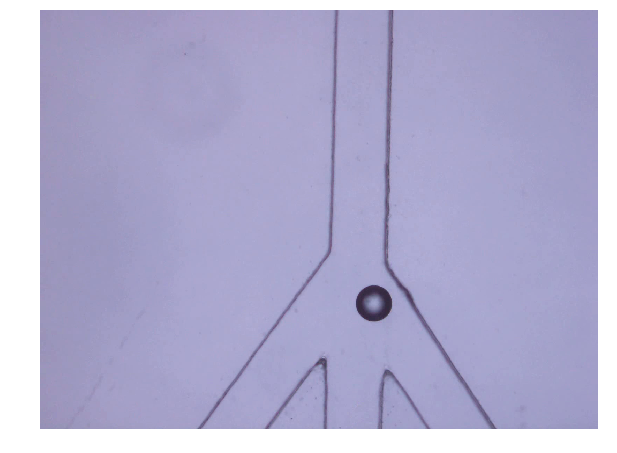

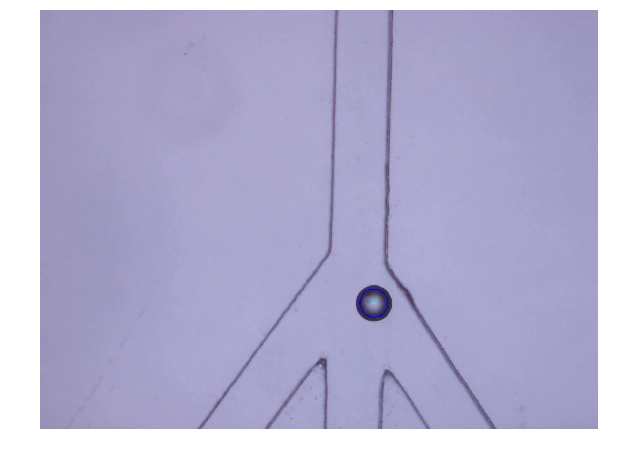

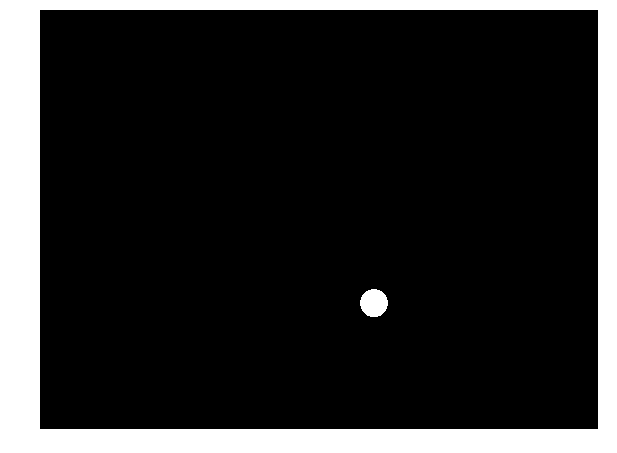

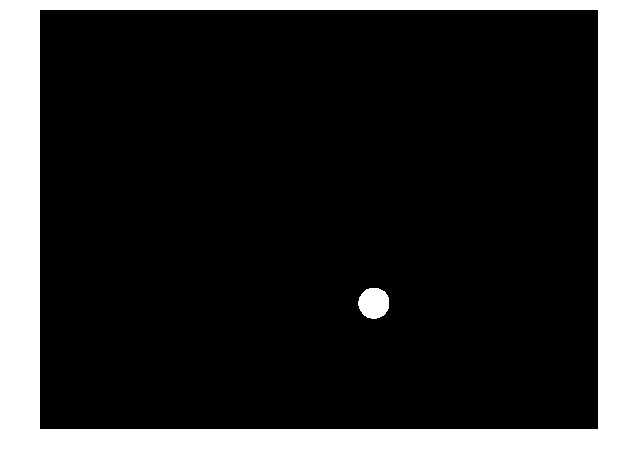

In [31]:
frames=frame_factory("D:\\project\\python\\worm\\src\\tobe.avi")
geodesic= geodesicActiveContourSegementation()
plt_show(frames[6])
orgin_gray= cv2.cvtColor(frames[6], cv2.COLOR_BGR2GRAY)
num,circles = hough_transfer(orgin_gray,param1=80,param2=40,minRadius=30,maxRadius=250)
circles=circles[0].astype(np.uint32)
#img= plot_circles(frames[6],circles)
mask,img=plot_circles_(frames[6],circles)
plt_show(img)
plt_show(mask)
im= sitk.GetArrayFromImage(geodesic.execute(orgin_gray,mask))
plt_show(im)

1
((225.63040161132812, 192.5995330810547), (302.7745056152344, 309.2298278808594), 7.622043609619141)


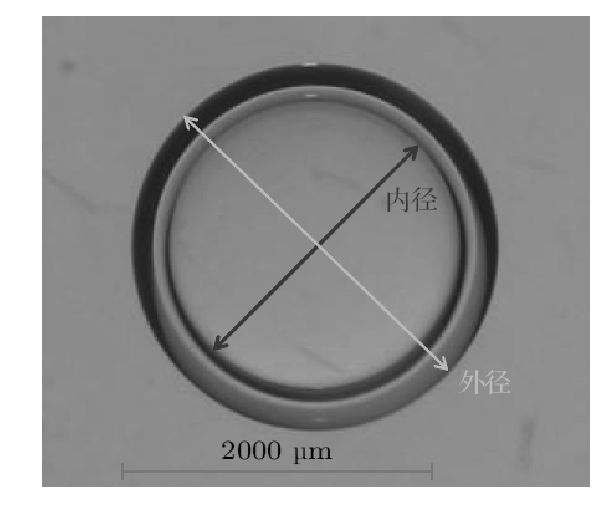

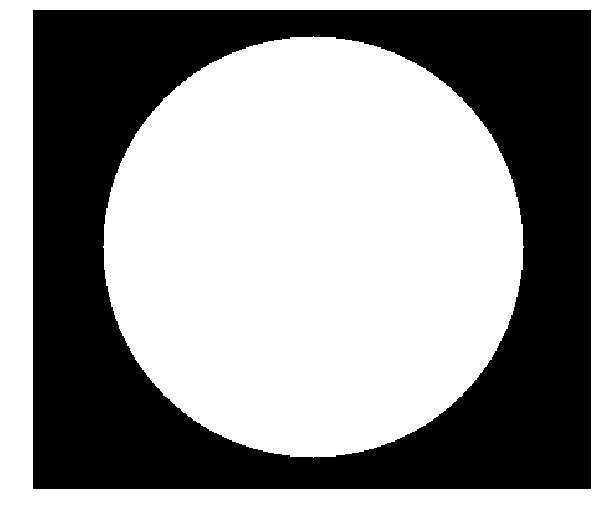

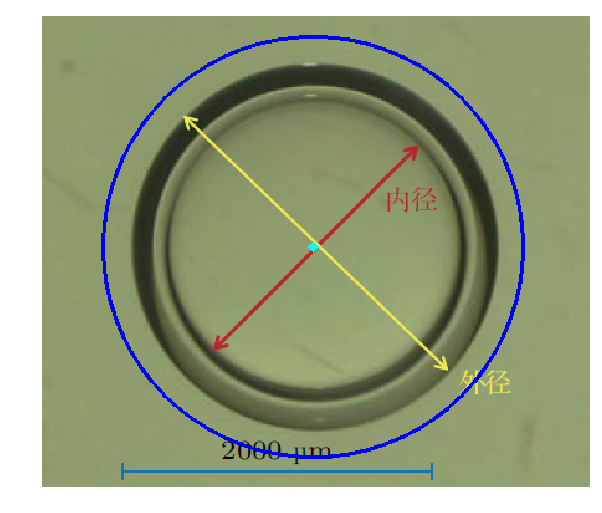

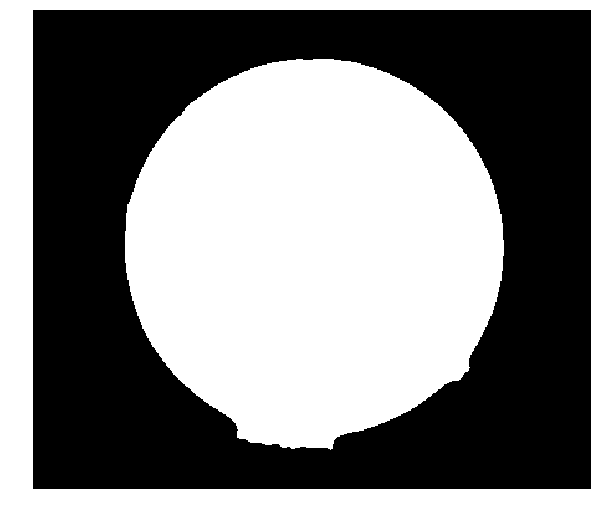

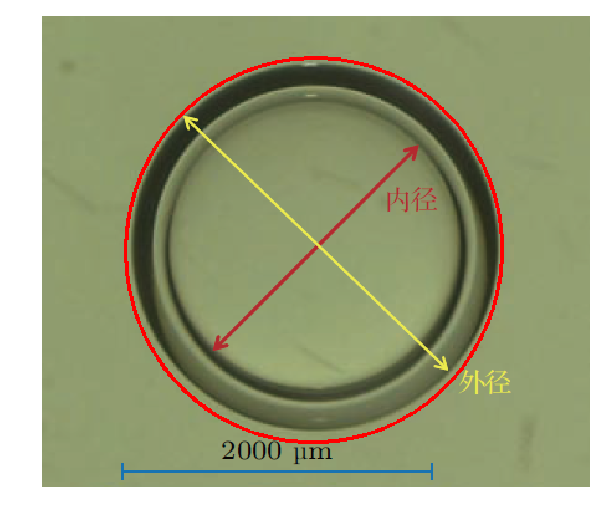

In [36]:
img=cv2.imread('C:\\Users\\steve\\Desktop\\img\\banjin.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
geodesic= geodesicActiveContourSegementation()
plt_show(gray)
num,circles = hough_transfer(gray,param1=80,param2=40,minRadius=100,maxRadius=160)
print(num)
circles=circles[0].astype(np.uint32)
mask,img_=plot_circles_(img.copy(),circles)
plt_show(mask)
plt_show(img_)
im= sitk.GetArrayFromImage(geodesic.execute(gray,mask))
plt_show(im)
(_,contours, _) = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
eclipse=np.squeeze(contours[0], axis=1)
_ellipse = cv2.fitEllipse(eclipse)
print(_ellipse)
eli=cv2.ellipse(img.copy(), _ellipse, (255,0,0),2)
plt_show(eli)

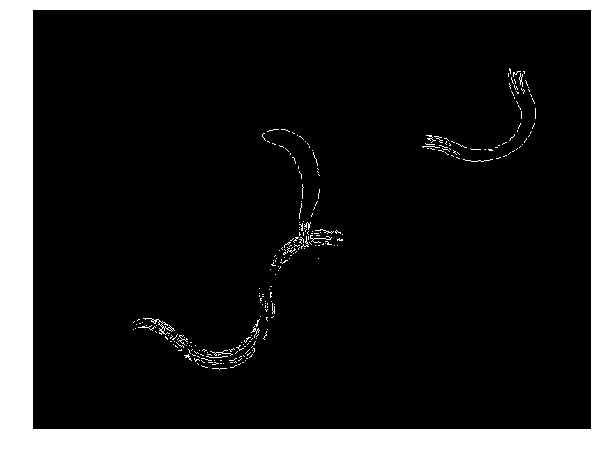

In [11]:
shape_filter(bg)

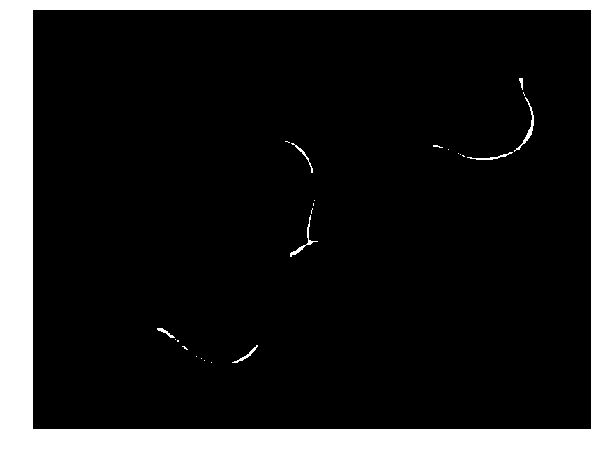

In [12]:
image,contours,hier = cv2.findContours(fg_1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
image_=cv2.drawContours(image,contours,-1,(0,0,255),3) 
plt_show(image_)

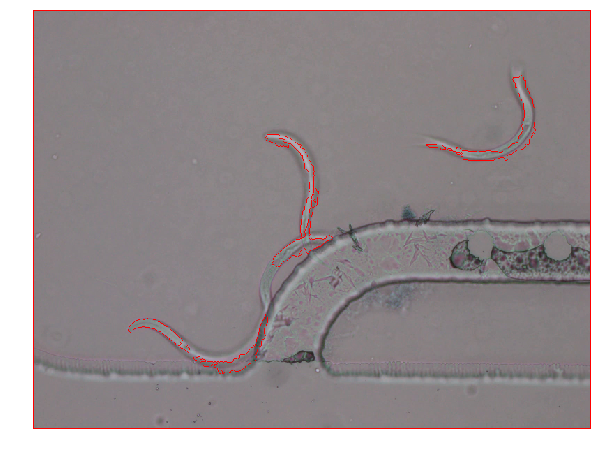

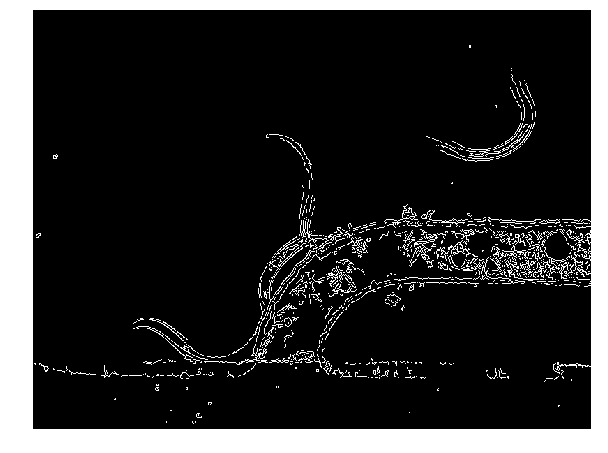

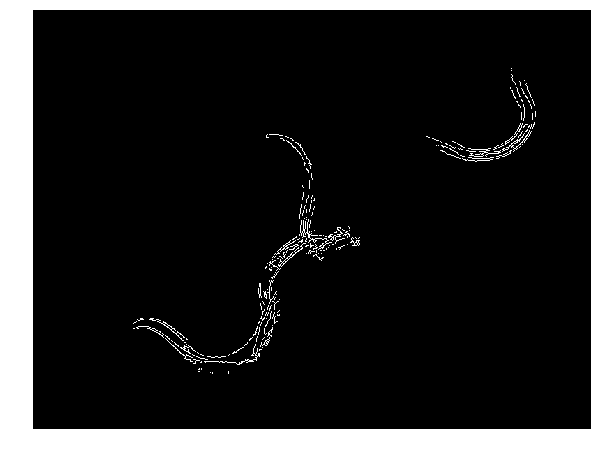

In [13]:
unknown = cv2.subtract(bg_1,fg_1) 
ret, markers = cv2.connectedComponents(fg_1)
markers = markers+1
markers[unknown==255] =0
markers = cv2.watershed(img,markers)
img[markers==-1]=(255,0,0)
edge=cv2.Canny(gray,40,110)
edge_=edge*bg_1
plt_show(img)
plt_show(edge)
plt_show(edge_)